#                         Lecture d'article: "Online EM for Functional Data"


Lien de l'article: https://hal.archives-ouvertes.fr/hal-01559315/document

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.integrate as integrate
import time
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,f.1,f.2,f.3,f.4,f.5,f.6,f.7,f.8,f.9,...,f.85,f.86,f.87,f.88,f.89,f.90,f.91,f.92,f.93,time
0,1,11.600000,16.800000,12.000000,17.200000,8.400000,9.200000,14.400000,19.600000,22.400000,...,12.400000,8.000000,10.400000,13.600000,12.800000,14.000000,20.000000,10.800000,9.20000,1.00
1,2,10.200000,14.000000,11.600000,17.000000,8.200000,8.600000,14.000000,18.400000,19.000000,...,12.200000,9.200000,10.200000,12.800000,11.400000,12.800000,20.000000,9.800000,12.40000,1.25
2,3,9.400000,10.000000,9.800000,14.000000,8.000000,10.600000,12.000000,14.200000,13.800000,...,11.200000,13.400000,11.400000,11.200000,10.600000,12.200000,20.000000,12.000000,15.20000,1.50
3,4,10.000000,8.800000,8.200000,11.000000,7.800000,12.600000,9.600000,10.800000,10.200000,...,10.400000,17.600000,11.200000,10.400000,10.800000,14.800000,20.600000,18.400000,13.80000,1.75
4,5,9.943339,9.090994,7.983877,11.089786,7.448715,10.321122,8.809463,9.973284,8.033191,...,10.000404,15.724447,9.733701,10.535178,10.480103,14.358556,17.933936,17.640186,11.74977,2.00


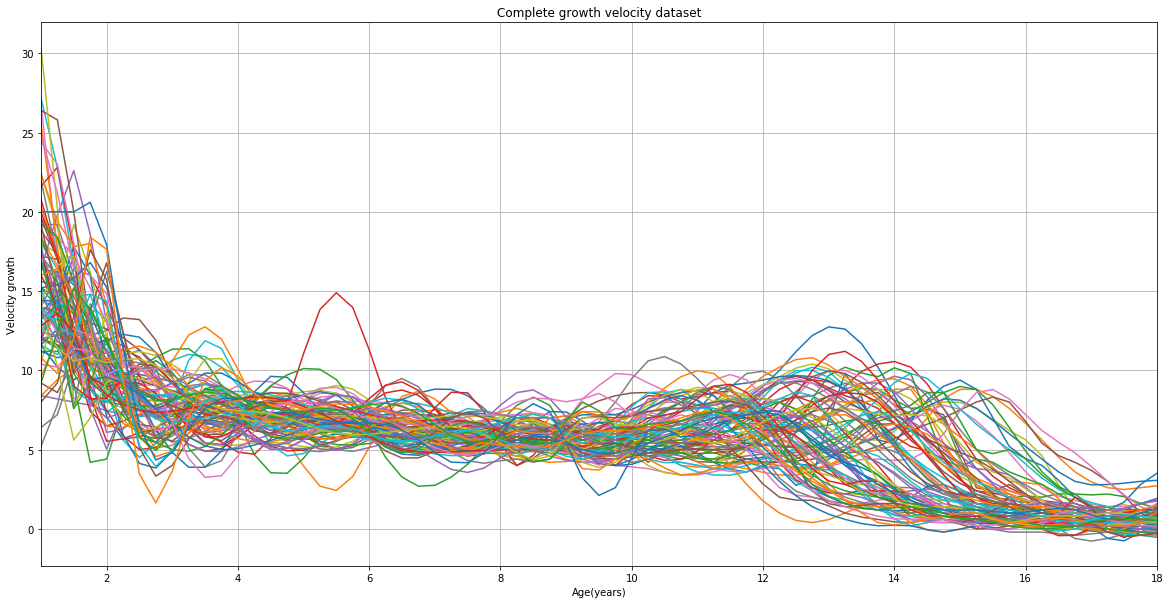

In [3]:
# Plot the whole dataset
val_col = ['f.'+str(i) for i in range(1,94)]
timestamps = data['time'].as_matrix()
velocities = data[val_col].as_matrix()

plt.figure(figsize = (20,10))
plt.xlim(1,18)
plt.grid(True)
plt.plot(timestamps,velocities)
plt.xlabel('Age(years)')
plt.ylabel('Velocity growth')
plt.title('Complete growth velocity dataset')
plt.show()


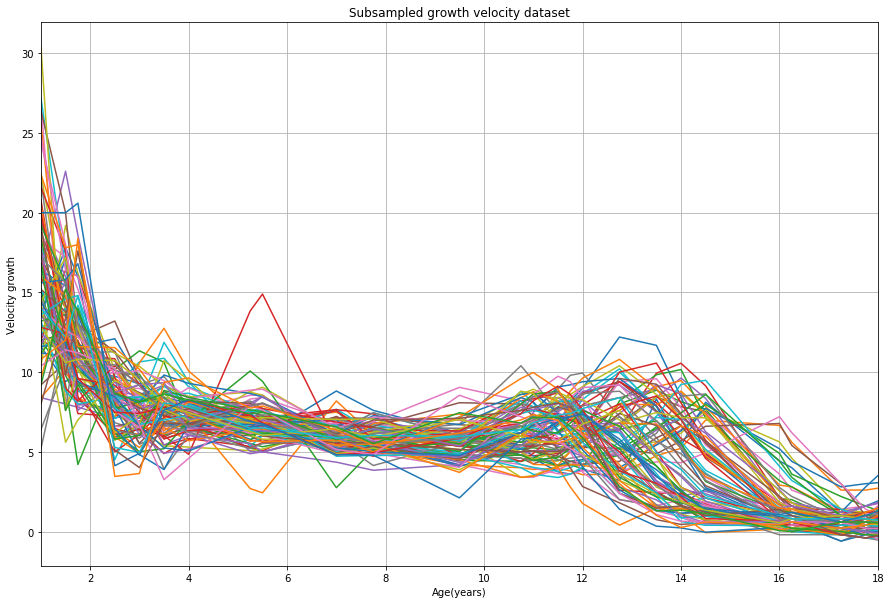

In [162]:
# Subsample the data
indices = np.sort(np.random.choice(np.shape(data)[0],31))
landmarks = timestamps[indices]
datas = velocities[indices]

fig = plt.figure(figsize = (15,10))
plt.xlim(1,18)
plt.grid(True)
plt.plot(landmarks,datas)
plt.xlabel('Age(years)')
plt.ylabel('Velocity growth')
plt.title('Subsampled growth velocity dataset')
fig.savefig('dataset')
plt.show()

In [1]:
datas = datas.T # datas[n] is the growth velocity curve of the n-th individual

NameError: name 'datas' is not defined

In [7]:
ui = 2
uf = 18

In [9]:
#we now define the model
m = 35
r = np.linspace(2,18,m)
u = datas[-1,:]
eps = 0.1
#before we define te phi function we define the parameters nu
nu = np.zeros(m)
for idx, k in enumerate(r) :
    tmp = min((u-k)**2)
    nu[idx] = -tmp/np.log(eps)

# Dictionary of templates
def phi(u,l):
    if nu[l]==0:
        if u == r[l] :
            return 0.1
        else:
            return 0
    else:
        return np.exp(-(1./nu[l])*(u-r[l])**2)
    
    
mm = 0
ss = 20
ui = 2
uf = 18
q = np.linspace(mm,ss,20)

def f(x,m,v):
    rv = multivariate_normal(m,v)
    return rv.pdf(x)

def gauss_ker(x,m, v = 1):
    return np.exp(-((x-m)/v)**2)

def h(u,beta):
    d = np.shape(beta)[0]
    tmp = np.array([gauss_ker(u,q[k],1) for k in range(d)])
    return np.exp(np.dot(beta,tmp))

def H(u,beta):
    r1 = integrate.quad(lambda x: h(x,beta), mm, u)[0]
    r2 = integrate.quad(lambda x: h(x,beta), mm, ss)[0]
    return r1/r2

def D(u,beta):
    return mi + (su - mi)*H(u,beta)


    
#we define the matrix PHI
def PHI(beta , u):
    #d = np.shape(beta)[0]
    n = np.shape(u)[0]
    res = np.zeros([n,m])
    tmp = np.array([D(u[i],beta) for i in range(n)])
    for j in range(m):
        for i in range(n):
            res[i,j] = phi(tmp[i], j)
            #print(res[i,j])
    return res

beta = np.ones(20) + 0.2*np.random.randn(20)
t = [u[k] for k in range(31)]
be = [ D(u[k],beta) for k in range(31) ]
#plt.plot(range(31),t)
plt.plot(t, be)
plt.show()

t0 = time.time()
M = PHI(beta, u)
tf = time.time()-t0
print(tf)

NameError: global name 'mi' is not defined

In [ ]:
#the function we want to minimize in order to define the pseudo priors
def pseudo_priors_centers_f(sigma,alpha,a,b,cov,y, lam, beta):
    M = PHI(beta, u)
    n = np.shape(alpha)[0]
    ALPHA = np.reshape(alpha,[n,1])*np.reshape(alpha,[1,n])
    MMt = np.dot(M.T, M)
    tmp = 2*(lam/sigma**2) * np.dot(alpha,np.dot(M.T,y))
    tmp -= (lam/sigma)**2 * np.trace(np.dot(ALPHA, MMt))
    tmp -= np.dot(beta, np.dot(cov, beta)) 
    tmp = tmp - 2*b*lam + 2*(a-1)*np.log(lam)
    return -tmp

def pseudo_prior_centers(sigma,alpha,a,b,cov,y,j, Xinit):
    n = np.shape(Xinit)[0] - 1
    v = cov[j]*np.eye(n)
    obj = lambda x : pseudo_priors_centers_f(sigma,alpha,a,b,v,y, x[0] , x[1:])
    res = minimize(obj, Xinit, method='BFGS', options={'maxiter': 2, 'disp': True})
    return res

sigma = 1
cov = np.array([1,1])
a = 10
b = 10
j = 0
alpha = 5*np.random.rand(35)
y = datas[0,:]
Xinit = np.zeros(21)
Xinit[0]=1
Xinit[1:]=beta
res = pseudo_prior_centers(sigma,alpha,a,b,cov,y,j, Xinit)
res.x

In [ ]:
a = range(10)
a[:-1]

In [ ]:
def simulate(Y,C,m,alphas,gammas,omegas,sigma2,r):
    """
    Simulates the missing data using a Markov kernel
    
    Parameters
    ----------
    Y : observations
    C : Number of classes
    m : Length of the Markov Chain to sample from
    alphas,gammas,omegas,sigma : Current fit of parameters
    r : number of Random Walk Metropolis-Hastings moves
    
    Returns
    -------
    The Markov chain (I,X)
    """
    
    X = np.zeros((m,C))
    I = np.zeros(m)
    
    
    for j in range(C):
        X[0][j] = pseudo_prior(alphas,gammas,omegas,sigma2,j)
        
    for k in range(m):
        i = sample_class(Y,alphas,gammas,omegas,sigma2,X)
        I[k] = i
        
        
    return I,X

def S(X,Y):
    I = X[-1] # Class index 
    lam = X[-2] # lambda parameter
    beta = X[:-2] # deformation parameter
    phi_beta = PHI(beta) # deformation matrix
    tmp = {}
    
    
    tmp[1] = np.ones(2)
    tmp[2] = lam*np.dot(PHI_beta.T,Y)
    tmp[3] = lam**2 *np.dot(PHI_beta.T,PHI_beta)
    tmp[4] = np.outer(beta,beta)
    tmp[5] = np.linalg.norm(Y)**2
    tmp[6] = lam
    tmp[7] = np.log(lam)
    s = {}
    for i in range(7):
        
        s[i] = np.zeros(np.shape(tmp[i])+(2,))
        s[i][...,I] = tmp[i]
        
    return s

def MCoEM(theta,Y,C):
    """
    Updates the sequence of parameters using the Monte Carlo online EM
    
    Parameters
    ----------
    alphas,gammas,omegas,sigma : Current fit of parameters
    Y : observations (arrays of size 31)
    C : Number of classes
    m : Length of the Markov Chain that will be using to sample the missing data
    Returns
    -------
    alphas,gammas,omegas,sigma : The updated parameters 
    """
    N,card = np.shape(Y)
    # Initialization
    # Sufficient stats
    s = {}
    s[1] = np.zeros(2)
    s[2] = np.zeros((np.shape(alphas)[0] , 2))
    s[3] = np.zeros((np.shape(alphas)[0]),np.shape(alphas)[0],2)
    s[4] = np.zeros((np.shape(gammas[1]),2))
    s[5] = np.ones((1,2))
    s[6] = np.ones((1,2))
    s[7] = np.ones((1,2))
    
    for n in range(N):
        
        index = np.random.randint(N)
        obs = Y[index] # randomly chosen observation
        mit = 300
        # simulation step
        X = MCMC_simulate(Y,theta,miter=1000,iteration=100, C=2)
        
        # Stochastic approximation step
        rho = np.exp(-0.6*np.log(n+1))
        
        for ind in range(7):
            for j in range(2): 
                tmp = np.array([S(X[k],obs)[ind] for k in range(mit)])
                s[ind][...,j] = s[ind][...,j]*(1-rho) + np.mean(tmp)*rho
        
        # Maximization
        # 
        theta['alpha0'] = np.solve(s[3][...,0],s[2][...,0]) 
        alpha0 = theta['alpha0']
        theta['alpha1'] = np.solve(s[3][...,1],s[2][...,1]) 
        alpha1 = theta['alpha1']
        theta['omega0'] = s[1][...,0]/np.sum(s[1][...,0])
        theta['omega1'] = s[1][...,1]/np.sum(s[1][...,1])
        d_beta = np.shape(s[4][...,0])[0]
        theta['cov0'] = s[4][...,0]/(d_beta * s[1][...,0])
        theta['cov1'] = s[4][...,1]/(d_beta * s[1][...,1])
        theta['sigma'] = (1.0/card) * (-2*(np.dot(alpha0,s[2][...,0]) 
                                       +np.dot(alpha1,s[2][...,1]))
                                       +tr(np.dot(np.outer(alpha0,alpha0),s[3][...,0]))
                                       +tr(np.dot(np.outer(alpha1,alpha1),s[3][...,1]))
                                       +s[5][...,0]
                                       +s[5][...,1])
        
        
    return alphas,gammas,omegas,sigma2 
theta= {}
test= np.dot(np.linalg.pinv(PHI(beta)),Y[0])
theta['alpha0'] = test + 0.05*np.random.rand(35)
theta['alpha1'] = test + 0.5*np.random.rand(35)
theta['omega0'] = 0.4
theta['omega1'] = 0.6
theta['cov0'] = 0.08
theta['cov1'] = 0.07
theta['sigma'] = 1

MCoEM(theta,Y,2)

def sample_class(Y,alphas,gammas,omegas,sigma2,X):
    """
    Gibbs sampler for the class index
    
    Parameters
    ----------
    Y : observation
    alphas,gammas,omegas,sigma : Current fit of parameters
    X : missing data sampled at the previous iteration
        X[:-1] is the parameter beta 
        X[-1] is the parameter lambda
        
    Returns
    -------
    i : The class sampled 
    """
    n = np
    C,m = np.shape(alphas)
    beta,lam = X[:-1],X[-1]
    weights = np.zeros(C)
    for j in range(C):
        phi_beta = phi(beta,Y)
        cov = sigma2*np.eyes(n)
        mu = lam*np.dot(phi_beta,alpha[j])
        rv = multivariate_normal(mean = mu,cov= cov)
        weights[j] = rv.pdf(Y)
    return np.random.choice(range(C),p=weights)

def RWMH(Y,alphas,gammas,omegas,sigma2,X):
    """
    Random Walk Metropolis-Hastings move 
    Parameters
    ----------
    Y : observation
    alphas,gammas,omegas,sigma : Current fit of parameters
    X : missing data sampled at the previous iteration
        X[:-1] is the parameter beta 
        X[-1] is the parameter lambda
        
    Returns
    -------
    X : The updated hidden parameters
    """

In [ ]:
a = range(5)
b = range(1)
np.concatenate((a,b))

In [ ]:
mvn = multivariate_normal(0,1)

In [ ]:
mvn.pdf(0)

In [ ]:
1/np.sqrt(2*np.pi)

In [ ]:
help(sample_class)

In [ ]:
x = np.linspace(-100,100)
y = np.exp(2*np.exp(x**2)+3*np.exp(x**2))
plt.plot(x,y)
plt.xlim(-100,100)
plt.show()

In [ ]:
x**2

In [ ]:
x = np.linspace(0,100,1000)
def mother(x):
    if(np.abs(x)<2):
        return max(1-np.abs(x/2),0)
    else: 
        return 0

    
def f(x,mus,amps):
    res = 0
    for i in range(len(mus)):
        res+=amps[i]*mother(x-mus[i])
    return res
        
mus = 2*np.array(range(5))
amps = np.array(range(5))
y = np.array([f(e,mus,amps) for e in x])
plt.plot(x,y)

plt.show()
mus

In [39]:
mus

[0, 1, 2, 3, 4, 0, 1, 2, 3, 4]

In [25]:
np.abs(x)

array([ 5.        ,  4.79591837,  4.59183673,  4.3877551 ,  4.18367347,
        3.97959184,  3.7755102 ,  3.57142857,  3.36734694,  3.16326531,
        2.95918367,  2.75510204,  2.55102041,  2.34693878,  2.14285714,
        1.93877551,  1.73469388,  1.53061224,  1.32653061,  1.12244898,
        0.91836735,  0.71428571,  0.51020408,  0.30612245,  0.10204082,
        0.10204082,  0.30612245,  0.51020408,  0.71428571,  0.91836735,
        1.12244898,  1.32653061,  1.53061224,  1.73469388,  1.93877551,
        2.14285714,  2.34693878,  2.55102041,  2.75510204,  2.95918367,
        3.16326531,  3.36734694,  3.57142857,  3.7755102 ,  3.97959184,
        4.18367347,  4.3877551 ,  4.59183673,  4.79591837,  5.        ])

In [105]:
def SAE(obs,alphas,lambdas,gamma,Salphas,Slambdas):
    m = np.shape(alphas)[0]
    p = np.zeros(m)
    Sa = np.zeros(m)
    Sl = np.zeros(m)


    for j in range(m):
        p[j] = alphas[j]*lambdas[j]**obs*np.exp(-lambdas[j])
    p/=np.sum(p)
    
    for j in range(m):
        Sa[j] = (1-gamma)*Salphas[j] + gamma*p[j]
        Sl[j] = (1-gamma)*Slambdas[j] + gamma*p[j]*obs
    
    return Sa,Sl
def M(Sa,Sl):
    alphas = Sa
    lambdas = np.array([Sl[j]/Sa[j] for j in range(np.shape(alphas)[0])])
    return alphas, lambdas


def PMM(obs,al,lam,Sa,Sl,gamma,logL):
    """
    Updates the parameters of the model using the observation obs
    Parameters
    ----------
    obs : new observation
    al,lam : current parameters
    Sa,Sl : current sufficient statistics
    gamma : learning rate of the Stochastic approximation
    logL : current log likelihood
    """
    # SA E step
    Sa,Sl = SAE(obs,al,lam,gamma,Sa,Sl)
    # M step
    al,lam = M(Sa,Sl)
    
    logL_new = logL + np.log(np.sum([al[k]*poisson.pmf(obs,lam[k]) for k in range(np.shape(alphas)[0])]))

    return al,lam,Sa,Sl,logL_new
def iterate_PMM(obss):
    al = np.ones(4)
    al *= (1.0/np.sum(alphas0))
    lam = 50*np.random.rand(4)
    Sa = alphas
    Sl = alphas*lambdas
    logLs = np.zeros(np.shape(obss)[0])
    logL = 0
    gamma = 1
    for i,obs in enumerate(obss):
        gamma =  np.exp(-0.6*np.log(i+1))
        al,lam,Sa,Sl,logL = PMM(obs,al,lam,Sa,Sl,gamma,logL)
        logLs[i] = logL
    return al,lam,logLs

x = np.zeros(1000)
y = np.zeros(1000)
for i in range(np.shape(x)[0]):
    y[i] = np.random.choice(range(4),p = alphas)
    x[i] = poisson.rvs(mu = mus[int(y[i])])

al,lam,logLs = iterate_PMM(x)
plt.plot(range(np.)))


In [9]:
def logL(obs,pi,lambdas):
    """
    Computes the log likelihood associated with the observations obs, the weights pi and the poisson parameters lambdas
    """
    res = 0
    for i,x in enumerate(obs):
        tmp = np.sum([pi[k]*poisson.pmf(x,lambdas[k]) for k in range(np.shape(pi)[0])])
        res += np.log(tmp)
    return res

def SAE(obs,alphas,lambdas,gamma,Salphas,Slambdas):
    """
    Performs the Stochastic approximation - expectation step of the Online Em algorithm
    """
    m = np.shape(alphas)[0]
    p = np.zeros(m)
    Sa = np.zeros(m)
    Sl = np.zeros(m)

    for j in range(m):
        p[j] = alphas[j]*lambdas[j]**obs*np.exp(-lambdas[j])
    p/=np.sum(p)
    
    for j in range(m):
        Sa[j] = (1-gamma)*Salphas[j] + gamma*p[j]
        Sl[j] = (1-gamma)*Slambdas[j] + gamma*p[j]*obs
    
    return Sa,Sl

def M_Online(Sa,Sl):
    """
    Performs the maximization step of the online EM algorithm
    """
    alphas = Sa
    lambdas = np.array([Sl[j]/Sa[j] for j in range(np.shape(Sa)[0])])
    return alphas, lambdas


def Online_PMM(obs,alphas0,lambdas0,Niter):
    """
    Computes the parameters of a gaussian mixture model using the observations 
    """
    N = np.shape(obs)[0]
    # Initialization
    alphas = alphas0
    K = np.shape(alphas)[0]
    alpha_hist = np.zeros([Niter,K])
    alpha_hist[0] = alphas
    lambdas = lambdas0
    
    
    
    lambda_hist = np.zeros([Niter,K])
    lambda_hist[0] = lambdas
    
    Sa = alphas
    Sl = alphas*lambdas
    logLs = np.zeros(Niter)
    visited = np.zeros(Niter)
    
    
    # Online EM loops
    for k in range(Niter):
        indices = np.random.permutation(N)
        # Stochastic approximation step rate
        gamma = np.exp(-0.6*np.log(k+1))
        # random observation picked among the avaible data
        randobs = obs[indices[0]] 
        # SA E step
        Sa, Sl = SAE(randobs,alphas,lambdas,gamma,Sa,Sl)
        # M step
        alphas, lambdas = M_Online(Sa,Sl)
        alpha_hist[k] = alphas
        lambda_hist[k] = lambdas
        # Compute log likelihood
        logLs[k] = logL(obs,alphas,lambdas)
        
    return alpha_hist,lambda_hist

alphas0 = np.ones(2)
alphas0/= np.sum(alphas0)
lambdas0 = np.max(x)*np.random.rand(2)
alpha_hist_online,lambda_hist_online = Online_PMM(x,alphas0,lambdas0,50)
alpha_hist, lambda_hist = EM(x,alphas0,lambdas0,50)
plt.plot(np.abs(lambdas_true-lam_hist),label = "Batch EM")
plt.plot(np.abs(lambdas_true-lam_hist_online),label = "Online EM")
plt.legend()
plt.show()

/Users/raphaelromero/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
/Users/raphaelromero/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide
/Users/raphaelromero/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


ValueError: too many values to unpack

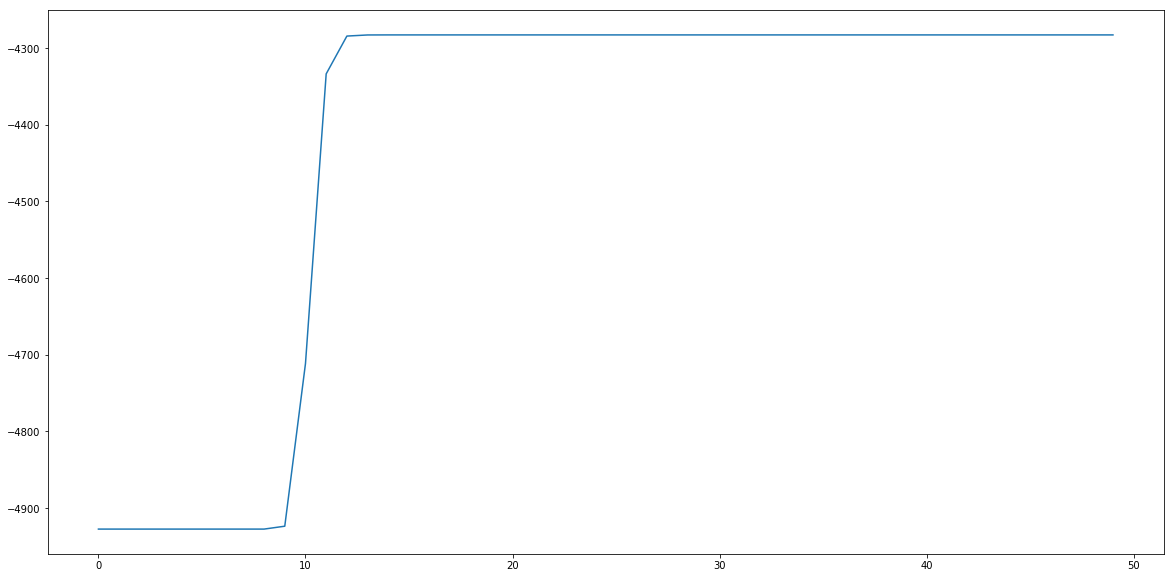

In [14]:
from scipy.stats import poisson
def E(obs,pi,lambdas):
    """
    Performs the expectation step of the EM algorithm on a poisson mixture
    """
    N = np.shape(obs)[0]
    K = np.shape(pi)[0]
    
    tau = np.zeros((N,K))
    # For each observation
    for i,x in enumerate(obs):
        #For each class
        for j in range(K):
            tau[i,j] = pi[j]*poisson.pmf(k=int(x),mu=lambdas[j])
        tau[i] *= (1.0/np.sum(tau[i]))
    return tau
def M(obs,tau):
    """
    Performs the maximizaton step of the EM algorithm on a poisson mixture
    """
    N,K = np.shape(tau)
    pi = np.zeros(K)
    lambdas = np.zeros(K)
    for j in range(K):
        Z = np.sum(tau[:,j])
        lambdas[j] = np.dot(obs,tau[:,j])
        lambdas[j] *= (1.0/Z)
        pi[j] = Z*(1.0/N)
    return pi,lambdas

def EM(obs,alphas0,lambdas0,Niter):
    """
    Performs the EM algorithm on a poisson mixture
    """
    K = np.shape(alphas0)[0]
    alphas = alphas0
    alpha_hist = np.zeros((Niter,K))
    alpha_hist[0] = alphas
    lambdas = lambdas0
    lambda_hist = np.zeros((Niter,K))
    lambda_hist[0] = lambdas
    logLs = np.zeros(Niter)
    for k in range(Niter):
        # E step
        tau = E(obs,alphas,lambdas)
        # M step
        alphas,lambdas = M(obs,tau)
        alpha_hist[k] = alphas
        lambda_hist[k] = lambdas
        # log likelihood
        logLs[k] = logL(obs,alphas,lambdas)
    return alphas,lambdas,logLs

def logL(obs,pi,lambdas):
    res = 0
    for i,x in enumerate(obs):
        tmp = np.sum([pi[k]*poisson.pmf(x,lambdas[k]) for k in range(np.shape(pi)[0])])
        
        res += np.log(tmp)
    return res

plt.figure(figsize = (20,10))
alphas,lambdas,logLS = EM(x,alphas0,lambdas0,50)
plt.plot(logLS)
plt.show()

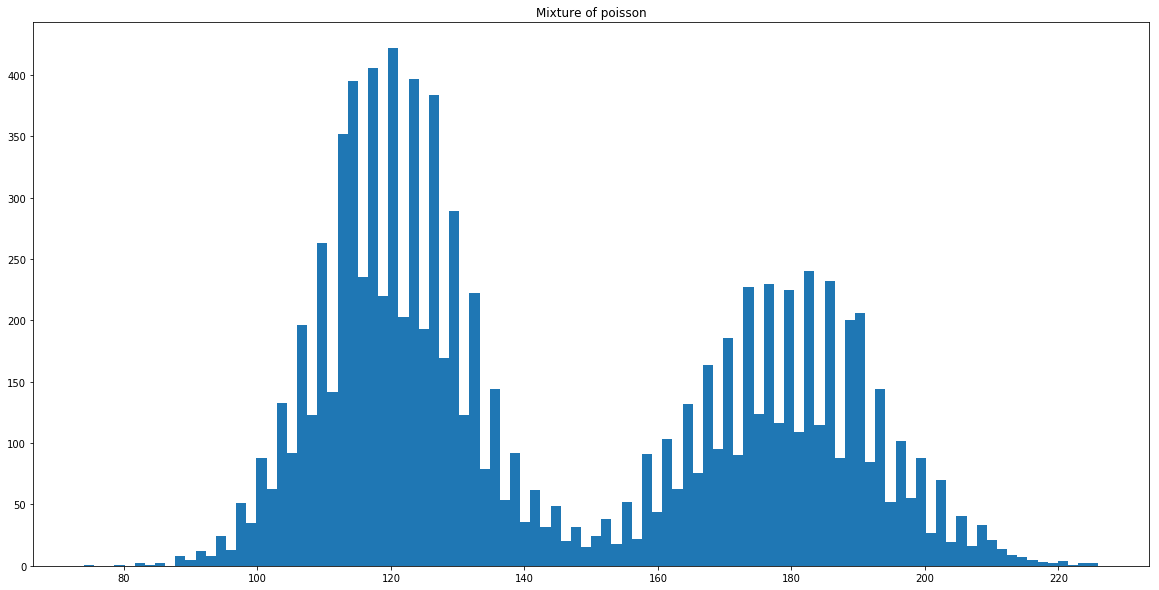

In [159]:
from scipy.stats import poisson


def gen_PMM(n_data,n_clusters):
    """
    Generates a dataset of integers following a mixture of poisson distribution
    """
    alphas = np.random.rand(n_clusters)
    s = (np.sum(alphas))
    alphas = alphas*(1.0/s)
    lambdas = (np.array(range(n_clusters))+2)*60 # means
    x = np.zeros(n_data)
    y = np.zeros(n_data)
    for i in range(n_data):
        y[i] = np.random.choice(range(n_clusters),p = alphas)
        x[i] = poisson.rvs(mu = lambdas[int(y[i])])
    fig = plt.figure(figsize = (20,10))
    
    plt.hist(x,bins = 100)
    plt.title("Mixture of poisson")
    plt.show()
    fig.savefig("mixpoiss.jpg")
    return x,alphas,lambdas

x,alpha_true,lambdas_true = gen_PMM(10000,2)
plt.figure(figsize = (12,6) )
mu = 10


('Time : ', 0.9733498096466064)


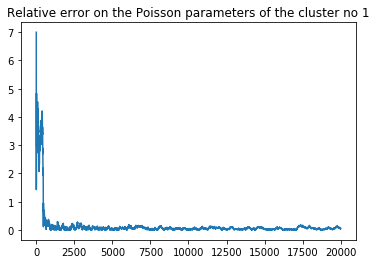

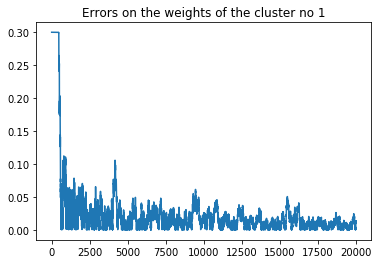

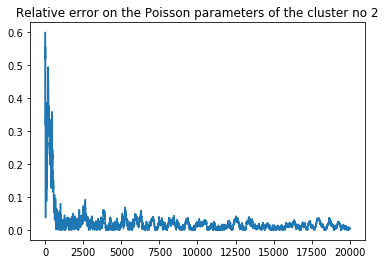

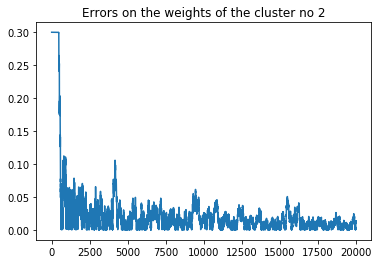

In [157]:
import time
def Online_PMM(Niter,Nobs,weights = [0.3,0.7],lambdas = [1.5,9.1]):
    """
    Computes the parameters of the poisson mixture model using the online EM
    """
    
    # Generate data 
    observations = np.zeros(Nobs)
    for i in range(Nobs):
        observations[i] = np.random.choice(poisson.rvs(lambdas),p=weights)
        
        
    K = np.shape(weights)[0]
    
    
    #initialization
    w_hist = np.zeros((Niter, K))
    w = np.ones(K) / K
    w_i = np.zeros(K)
    lam_hist = np.zeros((Niter, K))
    lam = np.array(range(1, K + 1))
    Sa = np.zeros(K)
    Sl = np.zeros(K)
    
    Sa = 1.0 / K
    Sl = np.array(range(1, K + 1))
    
    t0 = time.time()
    #loop
    for k in range(Niter):
        # Randomly chosen observation
        obs = observations[np.random.randint(Nobs)]
        gamma = np.exp(-0.6*np.log(k+1))

        # SA E step
        for j in range(K):
            w_i[j] = w[j] * lam[j]**obs * np.exp(-lam[j])
        w_i /= np.sum(w_i)

        Sa = Sa *(1-gamma) + gamma * w_i
        Sl = Sl *(1-gamma) + gamma * w_i * obs 
        w = Sa
        lam = Sl* (1.0/Sa)

        # M step
        w_hist[k, :] = w
        lam_hist[k, :] = lam

        
    lam_hist = np.sort(lam_hist,axis = 1)
    w_hist = np.sort(w_hist, axis = 1)
    t1 = time.time()-t0
    

    # Plot results
    print('Time : ', t1)
    for j in range(K):
        fig = plt.figure()
        plt.plot(np.abs(lam_hist[:,j] - lambdas[j])/lambdas[j])
        plt.title('Relative error on the Poisson parameters of the cluster no ' +str(j+1))
        plt.show()
        fig.savefig('oemlambda'+str(j+1))
        fig = plt.figure()
        plt.plot(np.abs(w_hist[:,j] - weights[j]))
        plt.title('Errors on the weights of the cluster no ' +str(j+1))
        plt.show()
        fig.savefig('oemw'+str(j+1))


        
        
        
    
    return w_hist, lam_hist




w_hist, lambdas_hist = Online_PMM(20000,10000)

In [147]:
w_hist

array([[ 0.57611688,  0.42388312],
       [ 0.57611688,  0.42388312],
       [ 0.57611688,  0.42388312],
       ..., 
       [ 0.74270747,  0.25729253],
       [ 0.73107155,  0.26892845],
       [ 0.73533372,  0.26466628]])

('Time : ', 6.711878061294556)


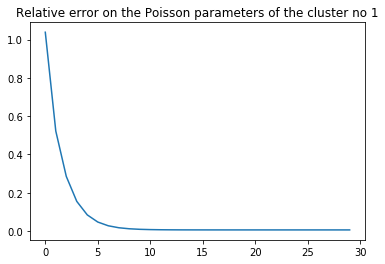

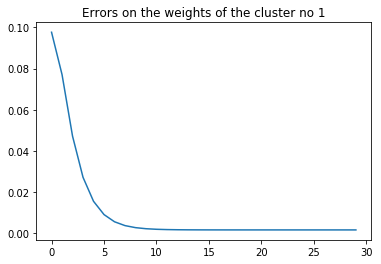

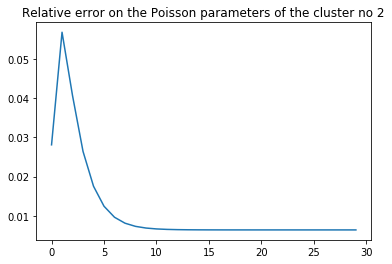

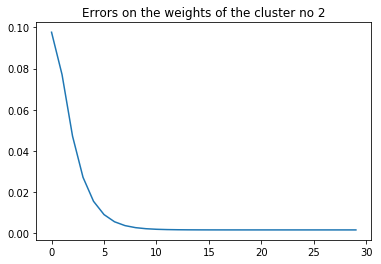

In [158]:

def PMM(Niter,Nobs,weights = [0.3,0.7],lambdas = [1.5,9.1]):
    """
    Computes the parameters of the poisson mixture model using the EM algorithm
    """
    K = np.shape(weights)[0]
    
    # Generate data 
    observations = np.zeros(Nobs)
    for i in range(Nobs):
        observations[i] = np.float(np.random.choice(poisson.rvs(lambdas),p=weights))
        
    # initialization
    
    
    tau = np.zeros((Nobs,K))

    w_hist = np.zeros((Niter, K))
    w = np.ones(K) / K
    lam_hist = np.zeros((Niter, K))
    lam = np.array([4.,7.])
    t0 = time.time()
    # loop
    for k in range(Niter):
                
        # E step            
        for i in range(Nobs):
            for j in range(K):
                tmp = w[j] * (lam[j]**observations[i]) * np.exp(-lam[j])
                tau[i,j] = tmp
            tmp1 = tau[i,:]*(1.0/np.sum(tau[i,:]))
            tau[i,:] = tmp1
        
        # M step
        for j in range(K):
            lam[j] = np.dot(observations,tau[:,j])
            lam[j] /= np.sum(tau[:,j])
            w[j] = np.mean(tau[:,j])
            
        w_hist[k] = w
        lam_hist[k] = lam
        
    t1 = time.time() - t0
    print('Time : ',t1)
    # Plot results
    for j in range(K):
        
        fig = plt.figure()
        plt.plot(np.abs(lam_hist[:,j] - lambdas[j])/lambdas[j])
        plt.title('Relative error on the Poisson parameters of the cluster no ' +str(j+1))
        plt.show()
        fig.savefig('emlambda'+str(j+1))
        fig = plt.figure()
        plt.plot(np.abs(w_hist[:,j] - weights[j]))
        plt.title('Errors on the weights of the cluster no ' +str(j+1))
        plt.show()
        fig.savefig('emw'+str(j+1))


        
        
    
        
    return w_hist, lam_hist
    
w_hist, lam_hist = PMM(30,10000)

In [132]:
lam_hist


array([[ 5.02584392,  8.17334211],
       [ 3.52711923,  9.41881343],
       [ 2.6174289 ,  9.73214213],
       [ 2.12305586,  9.54688587],
       [ 1.82245885,  9.36626327],
       [ 1.65456621,  9.24796109],
       [ 1.56743301,  9.17897065],
       [ 1.52348738,  9.1413236 ],
       [ 1.50146946,  9.12157341],
       [ 1.49044112,  9.11143267]])

In [433]:
a = np.zeros((10,5))
a

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [439]:
b = np.zeros(np.shape(a)+(3,))
np.shape(b)

(10, 5, 3)

In [440]:
dico[2] = a

In [442]:
dico[2][1]

array([ 0.,  0.,  0.,  0.,  0.])

In [443]:
a[...,1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])